In this exercise I solve a deterministic growth model using simulated data generated from an economy with parameters $\beta = 0.95$, $\alpha = 0.3$, $A = 1.0$, $\delta = 0.05$, $\gamma = 2.0$. I initiate the variables of the mathematical program at the true values, which should make the optimization easy.

  likely near In[1]:2
  likely near In[1]:2



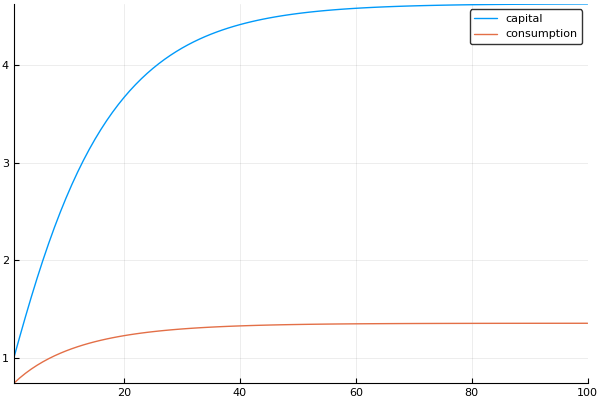

In [1]:
using CSV
using Plots; pyplot()

df = CSV.read("data.csv"; header=false, types=[Float64, Float64])
dataK = convert(Vector{Float64}, df[1])
dataC = convert(Vector{Float64}, df[2])

plot(dataK, label="capital")
plot!(dataC, label="consumption")

The economy's steady state for capital is:

In [2]:
k_stst = 4.628988089138438;

# The Mathematical Program
I define the needed function related to utility and production:

In [3]:
u_crra_prime(c, γ) = begin
    if (c <= 0)
        warn("u_crra_prime")
        return -1000000.
        else
        return c^-γ
    end
end

u_crra_prime_inv(u, γ) = begin
    if (u <= 0)
        warn("u_crra_prime_inv")
        return +1000000.
    else
        return u^(-1/γ) 
    end
end

function f(k, α, A)
    if (k <= 0)
        warn("f")
        return zero(k)
    else
        A*k^α
    end
end

function f_prime(k, α, A)
    if (k <= 0)
        warn("f_prime")
        return zero(k)
    else
        A*α*k^(α-1)
    end
end

f_prime (generic function with 1 method)

I use the Julia Mathematical Programming languange JuMP and the IpOpt solver:

In [4]:
using JuMP
using Ipopt

m = Model(solver=IpoptSolver(print_level=3, max_iter=700));

I define the deep parameters variables and give the the correct starting values:

In [290]:
@variable(m, 0 <= β <= 1, start = 0.80)
@variable(m, 0 <= δ <= 1, start = 0.5)
@variable(m, 0 <= α <= 1, start = 0.5)
@variable(m, A >= 0, start = 1)
@variable(m, γ >= 0, start = 5);

The policy function is approximated by 10 Chebyshev polynomials on a grid around the steady state for capital, the coefficients on the polynomials are $\theta$:

In [291]:
@variable(m, θ[1:10], start = 0);

I define a grid on capital, $K$, with 10 nodes, and evaluate the Chebyshev polynomials at those point into $\Psi$ and at the observed data points into $\Phi$:

In [292]:
using BasisMatrices
basis = Basis(ChebParams(10, 0.2*k_stst, 2*k_stst))
K = nodes(basis)[1] #grid
Ψ = BasisMatrix(basis, Expanded(), K).vals[1]
Φ = BasisMatrix(basis, Expanded(), dataK).vals[1];

And I initialize $\theta$ such that the consumer myopically consumes almost everything available, leaving just $0.5$ capital for the next period:

In [293]:
initial_θ = Ψ \ (f.(K, getvalue(α), getvalue(A)) + (1-getvalue(δ))*K - 0.5)

for i in 1:10
    setvalue(θ[i], initial_θ[i])
end

In the equilibrium constraint the polynomials have to be evaluated also outside the grid, I define this function here:

In [294]:
function Ψprime(x::Real, order::Integer) 
    return evalbase(params, [x], 0)[order]
end

Ψprime (generic function with 3 methods)

I register all user-defined functions with JuMP for automatic differentiation:

In [295]:
JuMP.register(m, :Ψprime, 2, Ψprime, autodiff=true)
JuMP.register(m, :u_crra_prime, 2, u_crra_prime, autodiff=true)
JuMP.register(m, :f, 3, f, autodiff=true)
JuMP.register(m, :f_prime, 3, f_prime, autodiff=true)
JuMP.register(m, :u_crra_prime_inv, 2, u_crra_prime_inv, autodiff=true)

The equilibrium constraints are all defined on the grid with 10 nodes:

In [296]:
@NLconstraint(m, EE[i=1:10], sum(Ψ[i, k] * θ[k] for k in 1:10) == 
    u_crra_prime_inv(
    β * u_crra_prime(sum(Ψprime(f(K[i], α, A) + (1-δ)*K[i] - sum(Ψ[i, k] * θ[k] for k in 1:10), k) * θ[k] for k in 1:10), γ) * 
    (f_prime(f(K[i], α, A) + (1-δ)*K[i] - sum(Ψ[i, k] * θ[k] for k in 1:10), α, A) + 1-δ)
    , γ));

I define auxiliary expressions for the predictions of the equilibrium conditions:

In [297]:
@NLexpression(m, predictedK[t=2:100], f(dataK[t-1], α, A) + (1-δ)*dataK[t-1] - dataC[t-1])
@NLexpression(m, predictedC[t=1:100], sum(Φ[t, k] * θ[k] for k in 1:10));

The objective is to minimize the sum of squared errors:

In [298]:
@NLobjective(m, Min, sum((dataC[t] - predictedC[t])^2 for t in 1:100) +
    sum((dataK[t] - predictedK[t])^2 for t in 2:100))

In [299]:
solve(m)

Total number of variables............................:       15
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:       10
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0




Number of Iterations....: 700

                                   (scaled)                 (unscaled)
Objective...............:   5.4116291628439003e-06    6.1542271225726816e-05
Dual infeasibility......:   2.0456378694615605e-02    2.3263456678887132e-01
Constraint violation....:   3.7629252958026882e-07    3.7629252958026882e-07
Complementarity.........:   1.0872745865522187e-11    1.2364732595104975e-10
Overall NLP error.......:   2.0456378694615605e-02    2.3263456678887132e-01


Number of objective function evaluations             = 4327
Number of objective gradient evaluations             = 701
Number of equality constraint evaluations            = 4375
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 701
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total CPU secs in IPOPT (w/o function evaluations)   =      0.792
Total CPU secs in NLP function eval

:UserLimit

In [300]:
getvalue(β), getvalue(δ), getvalue(α), getvalue(A), getvalue(γ)

(0.9483760402694263, 0.04122327659654317, 0.2870558236368918, 0.9939133487562155, 1.9241801270454704)


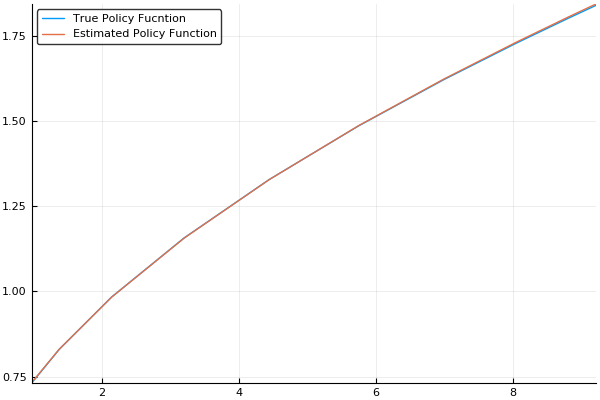

In [301]:
plot(nodes(Basis(ChebParams(10, 0.2*k_stst, 2*k_stst)))[1], [0.731039, 0.830067, 0.984055, 1.15697 , 1.32812 , 1.48555 , 1.62093 , 1.72778 , 1.80161 , 1.8393], label="True Policy Fucntion")
plot!(K, Ψ * getvalue(θ), label="Estimated Policy Function")